In [1]:
import sys
sys.path.append("../..")
import numpy as np
import sklearn.datasets as skd
import tqdm as tqdm

# visualization
import matplotlib.pyplot as plt
from scipy.stats import kde

# tf and friends
import tensorflow.compat.v1 as tf1
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers

import random

from transport_nets.distributions import BananaFlow

tf.enable_v2_behavior()

tfb = tfp.bijectors
tfd = tfp.distributions

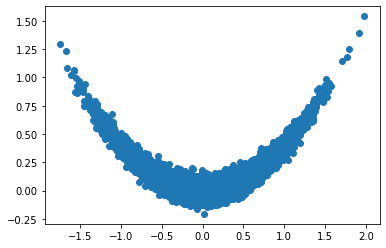

In [2]:
DATASET_SIZE = 10000
BATCH_SIZE = 200
SAMPLE_SIZE = DATASET_SIZE
OUTPUT_DIM = 2

params = (0.5,0.1,0.05,0.0) #(a1,a2,a3,theta)
bFlow = BananaFlow(params)
flip = tfb.Permute([1,0])
banana_yx = flip.forward(bFlow.sample(DATASET_SIZE))


banana_ds = tf.data.Dataset.from_tensor_slices(banana_yx)
banana_ds = banana_ds.prefetch(tf.data.experimental.AUTOTUNE)
banana_ds = banana_ds.cache()
banana_ds = banana_ds.shuffle(DATASET_SIZE).batch(BATCH_SIZE)

plt.scatter(banana_yx[:,1], banana_yx[:, 0])
plt.show()

In [3]:
from transport_nets.models import real_nvp_template
from transport_nets.models import MLP_ODE

class NF_TMAP(tf.keras.Model):
    def __init__(self,nvp_neurons,cnf_neurons,output_dim):
        super(NF_TMAP,self).__init__(name='nf_tmap')
        solver = tfp.math.ode.DormandPrince(atol=1e-5)
        ode_solve_fn = solver.solve
        # could also use trace_jacobian_hutchinson, which speeds up log density 
        # estimation significantly in higher dimensions O(D^2) -> O(D) 
        trace_augmentation_fn = tfb.ffjord.trace_jacobian_exact
        num_shift_scale_fns = 1
        num_mlp_models = 2
        bijectors = []
        self.shift_scale_fns = num_shift_scale_fns*[None]
        for i in range(num_shift_scale_fns):
            self.shift_scale_fns[i] = real_nvp_template(neuron_list=nvp_neurons)
        self.mlp_models = num_mlp_models*[None]
        for i in range(num_mlp_models):
            self.mlp_models[i] = MLP_ODE(output_dim=1,neuron_list=cnf_neurons)
        self.bn_vars = []
        
        # 1-D continuous flow for upper block
        ffjord_bij_1 = tfb.FFJORD(
                            state_time_derivative_fn=self.mlp_models[0],
                            ode_solve_fn=ode_solve_fn,
                            trace_augmentation_fn=trace_augmentation_fn)
        # applies FFJORD bijector to upper block of triangular map and identity to lower block
        blockwise_ffjord_bij_1 = tfb.Blockwise(
                                    bijectors=[ffjord_bij_1, tfb.Identity()], 
                                    block_sizes=[1, 1])
        
        nvp_bij_1 = tfb.RealNVP(num_masked = 1, 
                            shift_and_log_scale_fn = self.shift_scale_fns[0])
        
        
        
        bn_bij_1 = tfb.BatchNormalization()
        bn_bij_1(tf.random.normal([1,1]))
        self.bn_vars.append(bn_bij_1.trainable_variables)
        
        blockwise_bn_1 = tfb.Blockwise(
                            bijectors=[tfb.Identity(),bn_bij_1])
        
        
        ffjord_bij_2 = tfb.FFJORD(
                            state_time_derivative_fn=self.mlp_models[1],
                            ode_solve_fn=ode_solve_fn,
                            trace_augmentation_fn=trace_augmentation_fn)
        
        blockwise_ffjord_bij_2 = tfb.Blockwise(
                                    bijectors=[tfb.Identity(),ffjord_bij_2], 
                                    block_sizes=[1, 1])
        

        bijectors += [blockwise_ffjord_bij_1,
                      nvp_bij_1,
                      blockwise_bn_1,
                      blockwise_ffjord_bij_2
                      ] 

        # reversing bijector list and chaining together 
        stacked_bijectors = tfb.Chain(bijectors[::-1])
        
        base_loc = tf.zeros([output_dim],dtype=tf.float32)
        base_sigma = tf.ones([output_dim],dtype=tf.float32)
        base_distribution = tfd.MultivariateNormalDiag(base_loc, base_sigma)
        
        self.flow = tfd.TransformedDistribution(
            distribution=base_distribution, bijector=stacked_bijectors)
        
    @tf.function   
    def call(self,inputs):
        return self.flow.bijector.forward(inputs)
    
    @tf.function   
    def inverse(self,inputs):
        return self.flow.bijector.inverse(inputs)
    
    @tf.function   
    def sample(self,N):
        return self.flow.sample(N) 
    
    def batch_norm_mode(self,training=True):
        for bij in self.flow.bijector.bijectors:
            if bij.name == 'batch_normalization':
                bij.training = False

In [4]:
@tf.function
def train_step(model,optimizer, target_sample):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(target_sample))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

  0%|          | 0/50 [00:00<?, ?it/s]

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
loss: 2.1358376


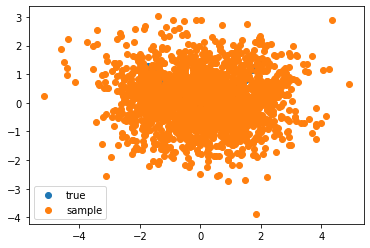

  2%|▏         | 1/50 [00:56<45:57, 56.27s/it]

loss: 2.4007397


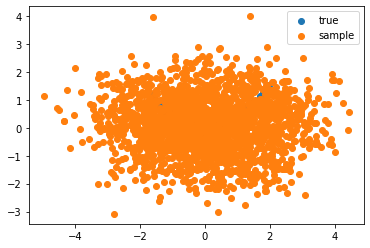

  4%|▍         | 2/50 [01:01<32:51, 41.08s/it]

loss: 2.6288877


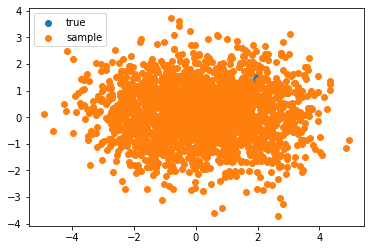

  6%|▌         | 3/50 [01:07<23:54, 30.51s/it]

loss: 2.8328977


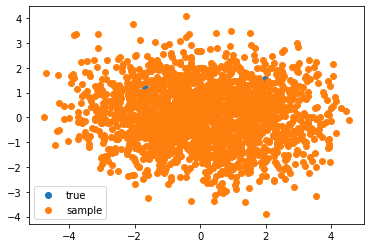

  8%|▊         | 4/50 [01:13<17:44, 23.14s/it]

loss: 3.014109


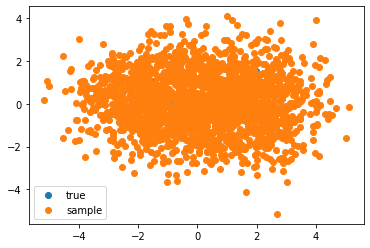

 10%|█         | 5/50 [01:19<13:32, 18.05s/it]

loss: 3.1789837


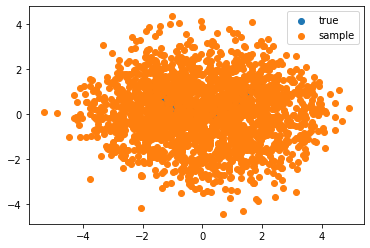

 12%|█▏        | 6/50 [01:25<10:35, 14.44s/it]

loss: 3.3349824


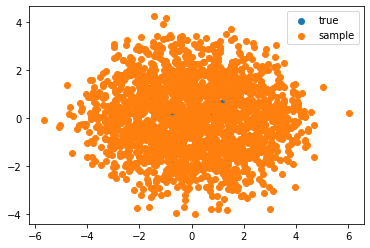

 14%|█▍        | 7/50 [01:31<08:32, 11.92s/it]

loss: 3.4751835


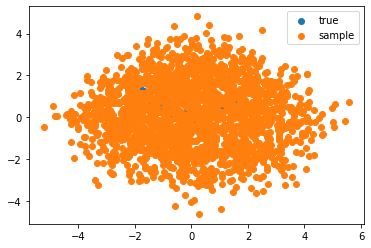

 16%|█▌        | 8/50 [01:38<07:11, 10.27s/it]

loss: 3.6031473


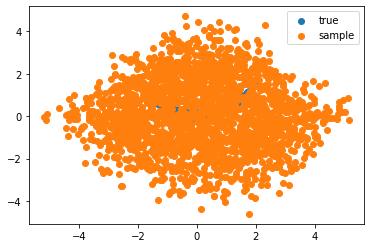

 18%|█▊        | 9/50 [01:45<06:16,  9.18s/it]

loss: 3.7259498


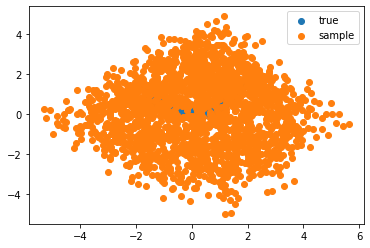

 20%|██        | 10/50 [01:51<05:37,  8.43s/it]

loss: 3.8321357


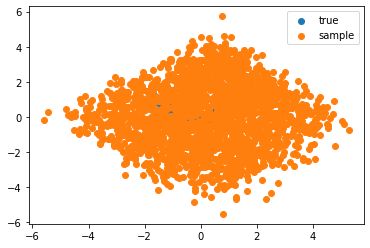

 22%|██▏       | 11/50 [01:58<05:12,  8.01s/it]

loss: 3.9377947


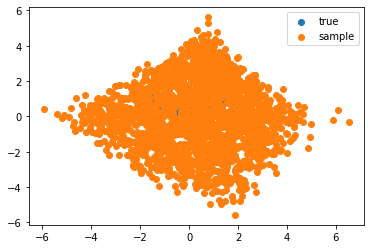

 24%|██▍       | 12/50 [02:05<04:54,  7.75s/it]

loss: 4.032855


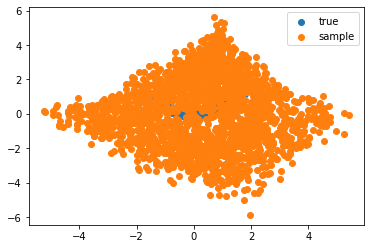

 26%|██▌       | 13/50 [02:12<04:38,  7.53s/it]

loss: 4.1247783


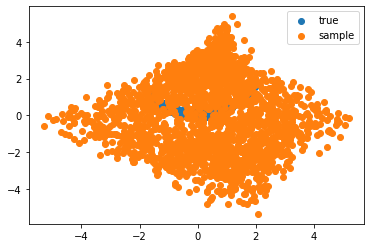

 28%|██▊       | 14/50 [02:20<04:31,  7.54s/it]

loss: 4.210465


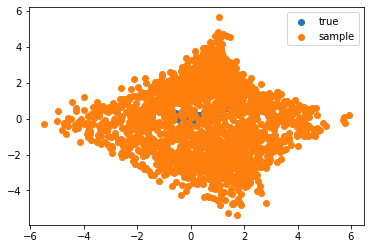

 30%|███       | 15/50 [02:27<04:20,  7.45s/it]

loss: 4.269383


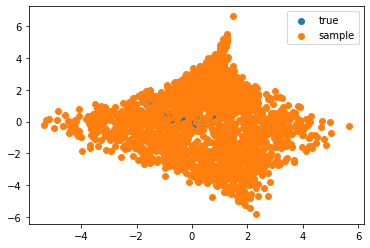

 32%|███▏      | 16/50 [02:35<04:12,  7.42s/it]

loss: 4.3479795


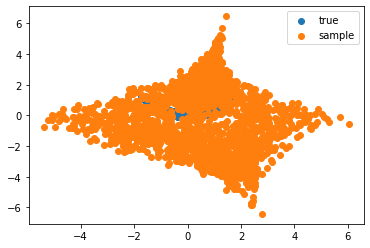

 34%|███▍      | 17/50 [02:42<04:05,  7.44s/it]

loss: 4.424335


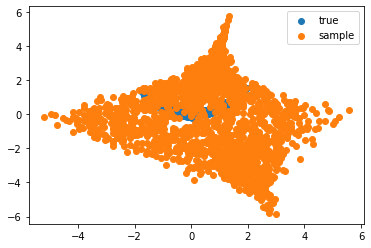

 36%|███▌      | 18/50 [02:50<03:59,  7.47s/it]

loss: 4.4921856


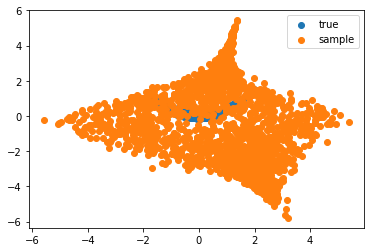

 38%|███▊      | 19/50 [02:57<03:53,  7.54s/it]

loss: 4.5791683


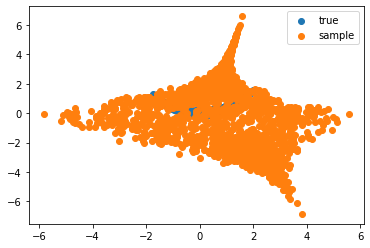

 40%|████      | 20/50 [03:06<03:54,  7.82s/it]

loss: 4.631456


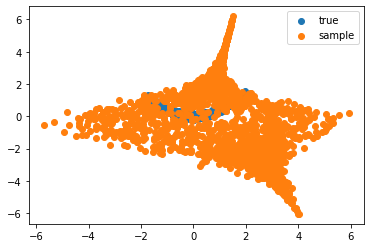

 42%|████▏     | 21/50 [03:15<03:57,  8.18s/it]

loss: 4.715358


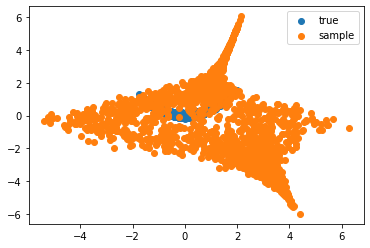

 44%|████▍     | 22/50 [03:24<03:57,  8.47s/it]

loss: 4.7941628


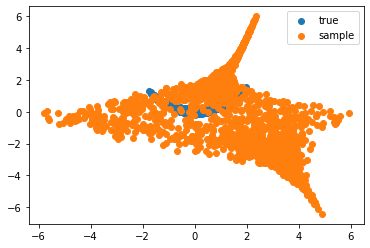

 46%|████▌     | 23/50 [03:34<03:58,  8.84s/it]

loss: 4.849892


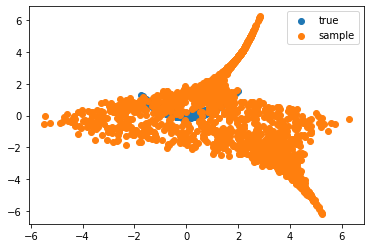

 48%|████▊     | 24/50 [03:43<03:54,  9.01s/it]

loss: 4.968432


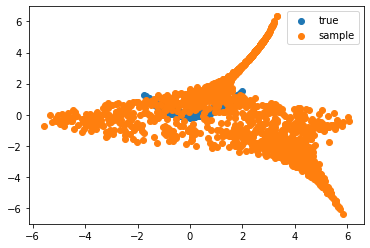

 50%|█████     | 25/50 [03:52<03:47,  9.09s/it]

loss: 5.052632


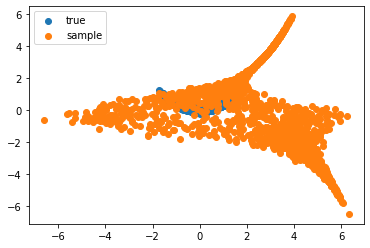

 52%|█████▏    | 26/50 [04:02<03:44,  9.33s/it]

loss: 5.1299453


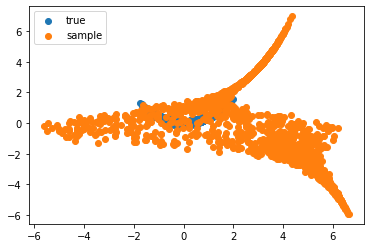

 54%|█████▍    | 27/50 [04:12<03:38,  9.50s/it]

loss: 5.2726665


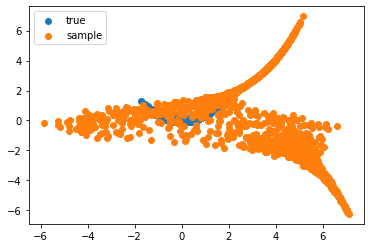

 56%|█████▌    | 28/50 [04:22<03:33,  9.69s/it]

loss: 5.382034


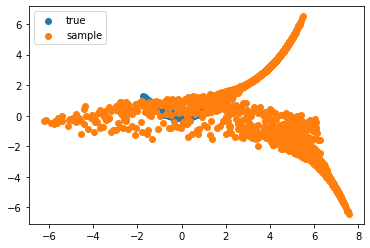

 58%|█████▊    | 29/50 [04:32<03:27,  9.86s/it]

loss: 5.494137


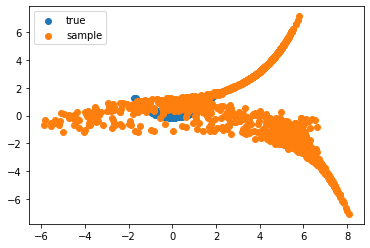

 60%|██████    | 30/50 [04:42<03:14,  9.74s/it]

loss: 5.618947


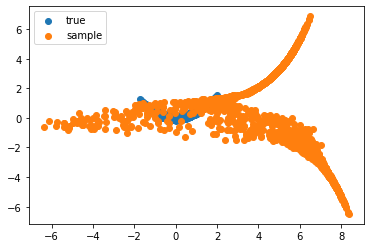

 62%|██████▏   | 31/50 [04:52<03:06,  9.80s/it]

loss: 5.743018


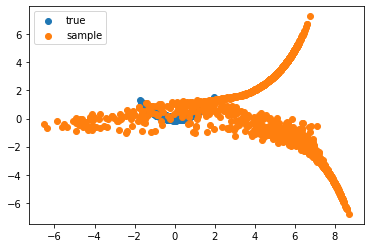

 64%|██████▍   | 32/50 [05:01<02:54,  9.70s/it]

loss: 5.6933293


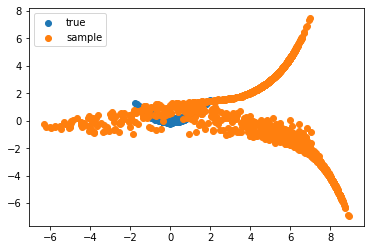

 66%|██████▌   | 33/50 [05:11<02:43,  9.62s/it]

loss: 5.7387514


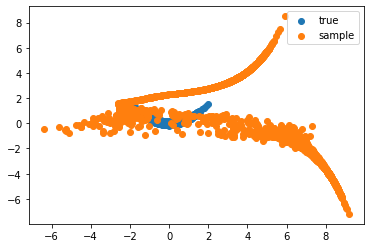

 68%|██████▊   | 34/50 [05:21<02:35,  9.74s/it]

loss: 5.929718


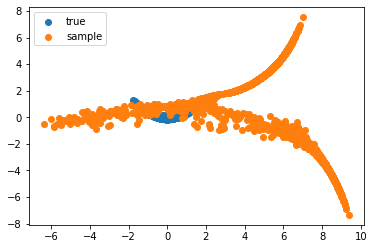

 70%|███████   | 35/50 [05:31<02:26,  9.75s/it]

loss: 5.9983854


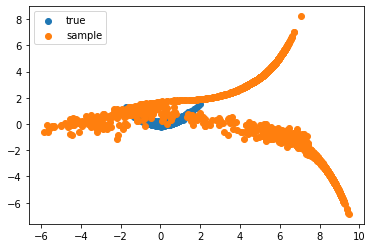

 72%|███████▏  | 36/50 [05:46<02:14,  9.61s/it]


KeyboardInterrupt: 

In [5]:
LR = 1e-2
NUM_EPOCHS = 100
optimizer = tf.optimizers.Adam(learning_rate=LR,epsilon=1e-8)
nf_tmap = NF_TMAP([20,20],[20,20],2)

for epoch in tqdm.trange(NUM_EPOCHS):
    for batch in banana_ds:
        loss = train_step(nf_tmap,optimizer, batch)
    if epoch % 1 == 0:
        print('loss:',loss.numpy())
        X = nf_tmap.sample(2000)
        plt.scatter(banana_yx[:,1], banana_yx[:, 0],label='true')
        plt.scatter(X[:,1],X[:,0],label='sample')
        plt.legend()
        plt.pause(0.05);

In [ ]:
X = nf_tmap.sample(1000)
plt.scatter(banana_yx[:,1], banana_yx[:, 0],label='true')
plt.scatter(X[:,1],X[:,0],label='sample')
plt.xlim(-3,3)
plt.legend();

In [ ]:
nf_tmap.batch_norm_mode(False)

In [ ]:
y_star = tf.constant([1.0],shape=[1,1])
y0 = tf.zeros([1,1])
r1 = nf_tmap.inverse(tf.concat([y_star,y0],axis=-1))[0,0]
Ns = 1000
target_cond = nf_tmap(tf.concat([r1*tf.ones([Ns,1]),tf.random.normal([Ns,1])],axis=-1))
X_cond = target_cond[:,1]
plt.hist(X_cond,50,density=True);

In [ ]:
nf_tmap.summary()

In [ ]:
import seaborn as sns
def plot_density(data,axis):
    x, y = np.squeeze(np.split(data, 2, axis=1))
    return sns.kdeplot(x, y, cmap="viridis", shade=True, 
                     shade_lowest=True, ax=axis)
xa,xb,ya,yb = (-1.5,1.5,-0.2,0.6)
fig,ax = plt.subplots(1,2,figsize=(10,4))
T = bFlow.sample(10000)
X = nf_tmap.sample(10000)
X_flipped = flip.forward(X)
l1 = plot_density(T,axis=ax[0])
l2 = plot_density(X_flipped,axis=ax[1])
ax[0].set(xlim=(xa,xb),ylim=(ya,yb))
ax[1].set(xlim=(xa,xb),ylim=(ya,yb))

ax[0].set_title('true map')
ax[1].set_title('LT-NF map')
#plt.savefig('images/NTNF_kde.png')

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(8,6))
x_obs_list = [0.4,0.2,0.0]
ax[0,0].scatter(T[:,0],T[:,1],alpha=0.2,label='true samples')
ax[0,0].scatter(X_flipped[:,0],X_flipped[:,1],alpha=0.2,label='LT-NF samples')
ax[0,0].plot(np.linspace(-2,2,100),x_obs_list[0]*np.ones(100),'r--')
ax[0,0].plot(np.linspace(-2,2,100),x_obs_list[1]*np.ones(100),'g--')
ax[0,0].plot(np.linspace(-2,2,100),x_obs_list[2]*np.ones(100),'--',c='purple')
ax[0,0].legend()

x_obs_list = [0.5,0.2,0.0]
y0 = tf.zeros([1,1])
x_obs1 = tf.constant(x_obs_list[0],shape=[1,1])
x_obs2 = tf.constant(x_obs_list[1],shape=[1,1])
x_obs3 = tf.constant(x_obs_list[2],shape=[1,1])

r1 = nf_tmap.inverse(tf.concat([x_obs1,y0],axis=-1))[0,0]
r2 = nf_tmap.inverse(tf.concat([x_obs2,y0],axis=-1))[0,0]
r3 = nf_tmap.inverse(tf.concat([x_obs3,y0],axis=-1))[0,0]

Ns = 2000

X_cond1 = nf_tmap(tf.concat([r1*tf.ones([Ns,1]),tf.random.normal([Ns,1])],axis=-1))[:,1]
X_cond2 = nf_tmap(tf.concat([r2*tf.ones([Ns,1]),tf.random.normal([Ns,1])],axis=-1))[:,1]
X_cond3 = nf_tmap(tf.concat([r3*tf.ones([Ns,1]),tf.random.normal([Ns,1])],axis=-1))[:,1]

ax[0,1].hist(X_cond1,40,color='r',density=True)
ax[1,0].hist(X_cond2,40,color='g',density=True)
ax[1,1].hist(X_cond3,40,color='purple',density=True)
plt.tight_layout()
#plt.savefig('images/LTNF_conditional_samples.png')